In [1]:
# http://stackoverflow.com/questions/44544766/ddg#44547144
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/ubuntu/.local/share/virtualenvs/DRIVENDATA_SUBMISSIONS/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/.local/share/virtualenvs/DRIVENDATA_SUBMISSIONS/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5301909290838469762
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 230948864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1005330540379171404
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
from matplotlib import pyplot as plt
import keras

Using TensorFlow backend.


In [3]:
def pd_read_csv(fn:str):
    x = pd.read_csv(fn, na_values=['NO_LABEL', '(blank)'])
    assert not x['Unnamed: 0'].duplicated().any()
    x = x.set_index("Unnamed: 0")
    return x

## Read data

In [4]:
train = pd_read_csv('data_in/TrainingData.csv')
test = pd_read_csv('data_in/TestData.csv')

/home/ubuntu/.local/share/virtualenvs/DRIVENDATA_SUBMISSIONS/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
# train.columns
train['Position_Type'].head()

Unnamed: 0
134338       Teacher
206341           NaN
326408       Teacher
364634    Substitute
47683        Teacher
Name: Position_Type, dtype: object

In [6]:
features = list(set(train.columns).intersection(set(test.columns)) - set(['FTE','Total']))
features.sort()
features

['Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4']

In [7]:
target = set(train.columns) - set(test.columns)
target = list(target)
target.sort()
target

['Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Use']

In [8]:
for col in target:
    test[col] = np.nan

In [9]:
train.shape, test.shape

((400277, 25), (50064, 25))

In [10]:
train['is_holdout'] = False
test ['is_holdout'] = True
df = pd.concat([train,test], axis=0)
df.shape

(450341, 26)

In [11]:
# Analyse FTE for classification
# df['FTE'].value_counts().iloc[:60].sum(), df['FTE'].value_counts().iloc[60:].sum(), pd.isnull(df['FTE']).sum()
# df['FTE'].value_counts().head(n=40).sum()
# df['FTE2'] = df['FTE'].round(1)
# df['FTE'].apply(lambda x: 'nan' if pd.isnull(x) else ( str(round(x,1)) if x <=1 else '>1' ) ).value_counts() # .shape # .tail()

In [12]:
# convert FTE to string boolean and append to list of features
# df['FTE'] = ~pd.isnull(df['FTE']).astype('str')
df['FTE'] = df['FTE'].apply(lambda x: 'nan' if pd.isnull(x) else ( str(round(x,1)) if x <=1 else '>1' ) )
features = features + ['FTE']
features.sort()
features

['FTE',
 'Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4']

In [13]:
# categorize Total field
def total_to_category(x):
    if pd.isnull(x): return 'nan'
    # if x < 1000: return str(round(x,1)) if x <=1 else '>1' ) )
    ranges = [10,100,1000,10000, 1e5]
    for i in ranges:
        if x < i: return str(int(x//(i//10)*(i//10)))
        
    return "> %s"%str(int(max(ranges)))

{x: total_to_category(x) for x in [1.5, 3.43, 15, 153, 2153, 9123, 42153, 142153]}

{1.5: '1',
 3.43: '3',
 15: '10',
 153: '100',
 2153: '2000',
 9123: '9000',
 42153: '40000',
 142153: '> 100000'}

In [14]:
df['Total'].apply(lambda x: total_to_category(x)).value_counts().head(n=20)

100         42082
1000        37297
200         23974
2000        18006
300         16289
10000       16143
50000       13880
400         13630
20000       13488
500         12885
3000        12012
30000       10052
40000        9452
> 100000     8750
600          8595
4000         8559
60000        7815
70           7780
700          7630
5000         7322
Name: Total, dtype: int64

In [15]:
df['Total'] = df['Total'].apply(lambda x: total_to_category(x))
features = features + ['Total']
features.sort()
features

['FTE',
 'Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4',
 'Total']

In [16]:
meta = list(set(df.columns) - set(features) - set(target))
meta

['is_holdout']

In [17]:
df.shape, df[features].shape, df[target].shape, df[meta].shape

((450341, 26), (450341, 16), (450341, 9), (450341, 1))

## Analyze how close the train and test features are

In [18]:
results = []
for ff in features:
    vc_train = train[ff].value_counts()
    vc_test  = test [ff].value_counts()
    # vc_train.shape, vc_test.shape
    vc_both  = vc_train.reset_index().merge(
        vc_test.reset_index(), 
        left_on = 'index', 
        right_on='index', 
        how='outer', 
        suffixes=['_train', '_test']
    )
    vc_both = vc_both.set_index('index')
    # vc_both.head()
    # vc_both[pd.isnull(vc_both['Facility_or_Department_test'])].head()
    out = {
        'feature': ff,
        'train all': train.shape[0],
        # 'train': vc_both['%s_train'%ff].sum(),
        'train non-null': (~pd.isnull(train[ff])).sum(),
        'train_minus_test': vc_both['%s_train'%ff][pd.isnull(vc_both['%s_test'%ff ])].sum(), 
        'test_minus_train': vc_both['%s_test'%ff ][pd.isnull(vc_both['%s_train'%ff])].sum(),
    }
    out['tmt_pct'] = out['test_minus_train'] * 100 // out['train non-null']
    results.append(out)


results = pd.DataFrame(results)
results = results.set_index('feature').sort_index()
results = results.astype('uint32')

In [19]:
# results.shape
# results.head()
results[['train all', 'train non-null', 'train_minus_test', 'test_minus_train', 'tmt_pct']]

,train all,train non-null,train_minus_test,test_minus_train,tmt_pct
feature,,,,,
FTE,400277,126071,25537,1669,1
Facility_or_Department,400277,53886,542,1,0
Function_Description,400277,342152,1476,9344,2
Fund_Description,400277,202877,326,6765,3
Job_Title_Description,400277,277508,10378,16998,6
Location_Description,400277,162054,1018,6581,4
Object_Description,400277,375493,1119,25986,6
Position_Extra,400277,264764,2013,2,0
Program_Description,400277,304659,1186,10300,3


In [20]:
# sod = train['Sub_Object_Description'].value_counts()
sod = test['Sub_Object_Description'].value_counts()

In [21]:
sod.head(n=20)

General                                               19704
Line Item that is paid with Campus' money              2281
Cycle  (used for grants)                                607
Mobile Phone                                            499
Extra Duty Pay/Overtime For Support Personnel           459
Certificated Employees Salaries And Wages               437
Special Education                                       361
Salaries And Wages For Teachers And Other Professi      360
Salaries And Wages For Substitute Teachers              320
Pre-K                                                   317
General Supplies *                                      314
National Board                                          239
Choral Music                                            238
Salaries Or Wages For Support Personnel                 230
Band                                                    218
Account For Learning                                    218
Speech Therapist                        

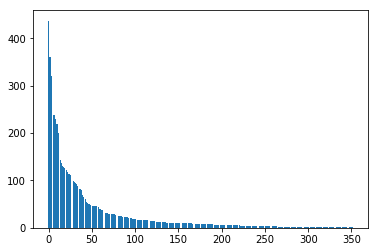

In [22]:
from matplotlib import pyplot as plt
# plt.bar(x=range(sod.shape[0]), height=sod.values)
plt.bar(x=range(sod.shape[0]-5), height=sod.iloc[5:].values)
plt.show()

In [23]:
# sod[sod<10].shape[0], sod.shape[0]
sod[sod<10]

Miscellaneous Operating Costs                    9
Consultants                                      9
Career Orientation                               9
English as a Second Language                     9
Extra Substitute Teachers Grant Funded           9
Community Ed-After School                        9
Community Ed-English/Sec Lang                    9
Energy Conservation - M & O                      9
Bus Charge from Transportation Department        9
Incentives (Participatory Activity)              8
Food                                             8
Test Prep                                        8
Student Discipline                               8
PAL                                              8
Dues And Fees *                                  8
Principal & Asst. Principal Support              8
Inservice Substitute Teachers Grant Funded       8
Teacher Induction Program                        7
Proportionate Shares of Funds-Special Ed Dept    7
Speech/Debate                  

In [24]:
subtest = test['Sub_Object_Description'].apply(lambda x: (~pd.isnull(x)) & ('community' in str(x).lower())) # .sum()

In [25]:
test['Sub_Object_Description'][subtest].head()

Unnamed: 0
0    Salaries Or Wages For Support Personnel
0    Salaries Or Wages For Support Personnel
0    Salaries Or Wages For Support Personnel
0    Salaries Or Wages For Support Personnel
0    Salaries Or Wages For Support Personnel
Name: Sub_Object_Description, dtype: object

## Read target labels

In [26]:
import yaml
labels = yaml.load(open("labels.yml",'r'))

In [27]:
# Function': ['Aides Compensation
prediction_names = []
for k,v1 in labels.items():
    for v2 in v1:
        pn = "%s__%s"%(k,v2)
        prediction_names.append(pn)
        
        
assert 'Function__Aides Compensation' in prediction_names
prediction_names.sort()
prediction_names[:5]

['Function__Aides Compensation',
 'Function__Career & Academic Counseling',
 'Function__Communications',
 'Function__Curriculum Development',
 'Function__Data Processing & Information Services']

## one-hot encode each target by its classes

In [28]:
for p in prediction_names: df[p] = False

In [29]:
for k,v1 in labels.items():
    for v2 in v1:
        pn = "%s__%s"%(k,v2)
        # print(pn)
        df[pn] = df[k] == v2

In [30]:
# since NO_LABEL is replaced with NaN, need this
for dependent in labels.keys():
    target_sub = [x for x in df.columns if x.startswith("%s__"%dependent)]
    df.loc[~df[target_sub].any(axis=1), '%s__NO_LABEL'%dependent]=True

In [31]:
df[['Function', 'Function__Teacher Compensation', 'Function__Substitute Compensation', 'Function__NO_LABEL']].head()

,Function,Function__Teacher Compensation,Function__Substitute Compensation,Function__NO_LABEL
Unnamed: 0,,,,
134338,Teacher Compensation,True,False,False
206341,NaN,False,False,True
326408,Teacher Compensation,True,False,False
364634,Substitute Compensation,False,True,False
47683,Substitute Compensation,False,True,False


In [32]:
df.shape, df[pd.isnull(df[prediction_names]).all(axis=1)].shape, df.loc[~df[prediction_names].any(axis=1)].shape

((450341, 131), (0, 131), (0, 131))

In [33]:
assert ~pd.isnull(df[prediction_names]).any().any()

In [34]:
df[prediction_names] = df[prediction_names].astype('uint8')

## Factorize features

In [35]:
print(time.ctime())
df_feat = df[features].apply(lambda x: pd.factorize(x)[0], axis=0)
df_feat = df_feat + 1 # +1 for the -1 from pd.factorize on nan (keras Embedding supports [0,N) )    
print(time.ctime())

Tue Apr 10 10:37:29 2018
Tue Apr 10 10:37:29 2018


In [36]:
df_feat.max().max(), df_feat.min().min()

(10786, 0)

In [37]:
vocab_size = df_feat.max(axis=0) + 1 # +1 to count the 0 index
vocab_size = vocab_size.sort_index()
vocab_size

FTE                          16
Facility_or_Department      181
Function_Description        705
Fund_Description            194
Job_Title_Description      4491
Location_Description        498
Object_Description          676
Position_Extra              583
Program_Description         433
SubFund_Description         274
Sub_Object_Description      421
Text_1                     1429
Text_2                      305
Text_3                       35
Text_4                      247
Total                     10787
dtype: int64

In [38]:
assert df[prediction_names].max().max()==1

## split the non-holdout into train/test

In [39]:
x = df_feat[~df['is_holdout']]
y = df[prediction_names][~df['is_holdout']] # .fillna(0)

from sklearn.model_selection import train_test_split
# test_size=0.33
test_size=0
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400277, 16), (0, 16), (400277, 105), (0, 105))

In [40]:
# calculate label_keys array whose order is replicable
label_keys = labels.keys()
label_keys = list(label_keys)
label_keys.sort()


## build a dummy equi-probable target

In [41]:
y_equi = {}
for k in label_keys:
    y_equi[k] = np.ones(shape=(y_train.shape[0], len(labels[k]))) / len(labels[k])

y_equi = [y_equi[k] for k in label_keys]
y_equi = np.concatenate(y_equi, axis=1)
y_equi = pd.DataFrame(y_equi, columns=y_train.columns, index=y_train.index)
y_equi.shape

(400277, 105)

In [42]:
y_equi.head()
# y_equi[0].head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
139668,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.111111,0.111111,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
446779,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.111111,0.111111,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
224958,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.111111,0.111111,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
386138,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.111111,0.111111,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
440032,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.111111,0.111111,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


## keras embedding + Dense/LSTM

In [43]:
from keras.layers import Embedding, Dense, Flatten, LSTM, Input, Concatenate, Add, Lambda, Dropout
from keras.models import Sequential, Model
from keras import backend as K

def build_fn():

    # vocab_size = stats.shape[0]

    # inputs = [Input(shape=(prob3.shape[1],)) for f in vocab_size.index]
    inputs = {f: Input(shape=(1,), name=f) for f in vocab_size.index}

    # embeddings = [Embedding(vocab_size[f], embedding_dim, input_length=prob3.shape[1]) for f in vocab_size.index]

    if True:
        embedding_dim = 10 # 3 # 12 # 2 # 64 # FIXME
        embeddings = {f: Embedding(vocab_size[f], embedding_dim, input_length=1)(inputs[f]) for f in vocab_size.index}
    else:
        embeddings = {f: Embedding(vocab_size[f], max(3, vocab_size[f]//15//10), input_length=1)(inputs[f]) for f in vocab_size.index}

    # the model will take as input an integer matrix of size (batch, input_length).
    # the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
    # now model.output_shape == (None, input_length, embedding_dim), where None is the batch dimension.

    # dummy variable
    x1= embeddings

    #  flatten each feature since no sequences anyway
    x1 = {f: Flatten(name="%s_flat"%f)(x1[f]) for f in vocab_size.index}

    # dense layer for each feature
    # x1 = {f: Dense(10, activation = 'relu', name="%s_d01"%f)(x1[f]) for f in vocab_size.index}
    # x1 = {f: Dense( 3, activation = 'relu', name="%s_d02"%f)(x1[f]) for f in vocab_size.index}

    # a dropout for each feature, this way, the network is more robust to dependencies on a single feature
    x1 = {f: Dropout(0.3, name="%s_dropout"%f)(x1[f]) for f in vocab_size.index}

    x1 = [x1[f] for f in vocab_size.index]
    x1 = Concatenate()(x1)
    # x1 = Flatten()(x1)
    x1 = Dropout(0.3)(x1)

    x1 = Dense(1000, activation='relu')(x1)
    x1 = Dense( 300, activation='relu')(x1)

    # x1 = Dense( 50, activation='relu')(x1)
    # o1 = {dependent: Dense(50, activation = 'relu', name="%s_d1"%dependent)(x1) for dependent in label_keys}
    # o1 = {dependent: Dense(50, activation = 'relu', name="%s_d2"%dependent)(o1[dependent]) for dependent in label_keys}

    # outputs = [Dense(len(labels[dependent]), activation = 'softmax', name="%s_out"%dependent)(o1[dependent]) for dependent in label_keys]
    outputs = [Dense(len(labels[dependent]), activation = 'softmax', name="%s_out"%dependent)(x1) for dependent in label_keys]

    inputs = [inputs[f] for f in vocab_size.index]
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    # model.compile('rmsprop', loss=multi_multiclass_logloss, metrics=['acc'])
    # model.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [44]:
from keras.wrappers.scikit_learn import BaseWrapper

class BaseWrapper2(BaseWrapper):
    """
    Mostly just a copy of the original class in order to introduce preprocess_feature and preprocess_target
    """
    def fit(self, x, y, **kwargs):
        if self.build_fn is None:
            self.model = self.__call__(**self.filter_sk_params(self.__call__))
        elif (not isinstance(self.build_fn, types.FunctionType) and
              not isinstance(self.build_fn, types.MethodType)):
            self.model = self.build_fn(
                **self.filter_sk_params(self.build_fn.__call__))
        else:
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn))

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__
        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)

        fit_args = copy.deepcopy(self.filter_sk_params(Sequential.fit))
        fit_args.update(kwargs)
        
        # new lines
        x = self.preprocess_feature(x) # <<<<<<<
        y = self.preprocess_target(y) # <<<<<<<

        history = self.model.fit(x, y, **fit_args)

        return history

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

class KerasClassifier2(KerasClassifier):
    def fit(self, x, y, **kwargs):
        y = np.array(y)
        if len(y.shape) == 2 and y.shape[1] > 1:
            self.classes_ = np.arange(y.shape[1])
        elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
            self.classes_ = np.unique(y)
            y = np.searchsorted(self.classes_, y)
        else:
            raise ValueError('Invalid shape for y: ' + str(y.shape))
        self.n_classes_ = len(self.classes_)
        return super(KerasClassifier, self).fit(x, y, **kwargs)


In [ ]:
class MyNetwork(KerasClassifier):
    def preprocess_feature(self, x):
        """
        convert 2-D matrix of features into array of 1-D features
        This is needed because each feature has a different vocabulary for its embedding
        """
        x = [x[f].values for f in vocab_size.index]
        return x
    
    def preprocess_target(self, y):
        """
        convert 2-D matrix of targets into K arrays of C-D matrices 
        where C is the number of classes of each target
        """
        y = [y[[x for x in prediction_names if x.startswith("%s__"%f)]].values for f in label_keys]
        return y
    
    def fit(self, x, y, **kwargs):
        x = self.preprocess_feature(x)
        y = self.preprocess_target(y)
        super().fit(x,y,**kwargs)
        
    def predict(self, x, **kwargs):
        x = self.preprocess_feature(x)
        super().predict(x,**kwargs)
        
    def predict_proba(self, x, **kwargs):
        x = self.preprocess_feature(x)
        super().predict_proba(x,**kwargs)
        
    def score(self, x, y, **kwargs):
        x = self.preprocess_feature(x)
        super().score(x,**kwargs)
        
    def __call__():
        build_fn()

In [ ]:
keras_clf = MyNetwork(build_fn=None, epochs=30, batch_size=32*32, verbose=0)

# from sklearn.cross_validation import StratifiedKFold
# skf = cross_validation.StratifiedKFold(y_train, n_folds=3, shuffle=True)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True)

from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(keras_clf, cv=skf, method='sigmoid')

In [ ]:
keras_clf.fit(x_train, y_train)

In [ ]:
# then train to actual probabilities
history = model.fit(x_train, y_train)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
model.evaluate(x_test, y_test, batch_size = 32*32)

## argmax accuracy

## Spatial comparison

In [ ]:
# sub_labels = labels
sub_labels = {k:labels[k] for k in label_keys if k in ['Function']}

n_show = 1000
y_pred = model.predict(x_test)

In [ ]:
for i,v0 in enumerate(sub_labels.items()):
    k,v1 = v0
    y_pred2 = pd.DataFrame(y_pred[i], columns=v1)
    y_test2 = pd.DataFrame(y_test[i], columns=v1)
    for v2 in v1:
        plt.figure(figsize=(20,3))
        plt.plot(y_pred2.loc[:n_show,v2], label='pred')
        #plt.plot(sum_pred, label='sum_pred', alpha=0.2)
        plt.plot(y_test2.loc[:n_show,v2], '.', label='actual')
        plt.legend(loc='best')
        plt.title("%s: %s"%(k,v2))

        axes = plt.gca()
        axes.set_ylim([-.1,1.1])
        plt.show()

In [ ]:
y_test[0][0,:].sum(), y_pred[0][0,:].sum() # , y_pred[0]

## temporal comparison

In [ ]:
y_pred = model.predict(x_test)
y_pred2 = {label_keys[i]: y_pred[i] for i in range(len(label_keys))}
y_test2 = {label_keys[i]: y_test[i] for i in range(len(label_keys))}

k2 = 'Function'
y_pred3 = y_pred2[k2]
y_test3 = y_test2[k2]

for i in range(15):
    plt.figure(figsize=(10,3))
    
    plt.subplot(121)
    plt.bar(x=range(y_pred3.shape[1]), height=y_test3[i])
    plt.title('%s. actual, argmax=%s'%(i,np.argmax(y_test3[i])))
    axes = plt.gca()
    axes.set_ylim([-.1,1.1])
    
    plt.subplot(122)
    plt.bar(x=range(y_pred3.shape[1]), height=y_pred3[i])
    plt.title('%s. prediction, argmax=%s'%(i,np.argmax(y_pred3[i])))
    axes = plt.gca()
    axes.set_ylim([-.1,1.1])
    
    # plt.title(y_test.index[i])
    
    plt.show()

In [ ]:
i=6
y_test3[i,:]

## Mock submission

In [ ]:
x_ho = df_feat[features][~df['is_holdout']].head()
x_ho  = [x_ho [f].values for f in vocab_size.index]
y_ho = model.predict(x_ho)
df_submit = pd.DataFrame(np.concatenate(y_ho, axis=1), columns=prediction_names)
df_submit.shape

In [ ]:
df_submit.head()

In [ ]:
df[target].head()

## Prepare submission

In [ ]:
df.shape, df_feat.shape

In [ ]:
x_ho = df_feat[features][ df['is_holdout']]
x_ho  = [x_ho [f].values for f in vocab_size.index]
y_ho = model.predict(x_ho)

In [ ]:
len(y_ho), y_ho[0].shape, y_ho[1].shape

In [ ]:
df_submit = pd.DataFrame(np.concatenate(y_ho, axis=1), columns=prediction_names, index=df_feat[ df['is_holdout']].index)
df_submit.shape

In [ ]:
df_submit.head()

In [ ]:
# plt.plot(df_submit['Use__NO_LABEL'].sort_values().values)
plt.plot(df_submit['Operating_Status__NO_LABEL'].sort_values().values)
plt.show()

In [ ]:
test.head()

In [ ]:
assert (df_submit['Operating_Status__NO_LABEL']<0.0001).all()
del df_submit['Operating_Status__NO_LABEL']

In [ ]:
fn = 'data_out/submission_C4_%s.csv'%(time.strftime("%Y%m%d_%H%M%S"))
df_submit.to_csv(fn)

## compare to C3

In [ ]:
fn = 'data_out/submission_C3_20180409_120904.csv'
df_c3 = pd.read_csv(fn).set_index("Unnamed: 0")

In [ ]:
(df_submit - df_c3).head(n=2).apply(lambda x: x.idxmax(), axis=1)

In [ ]:
df.loc[[180042,28872], ['FTE']].head(n=2)

In [ ]:
result = (df_submit - df_c3).max(axis=1)

In [ ]:
result.shape[0], result[abs(result) > 0.4].shape[0]

In [ ]:
result = df_submit.apply(lambda x: x.idxmax(), axis=1) != df_c3.apply(lambda x: x.idxmax(), axis=1)

In [ ]:
result.value_counts()

## RF